# SRM + STDP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Model

In [2]:
INPUT_SIZE, OUTPUT_SIZE = 20, 2
DELAY_MIN, DELAY_MAX = 1, 7
THRESHOLD = 1
INPUT_REPEAT = 5  # [5, 10].
T = 100  # Time.
TAU = 1
T_S = 1

In [3]:
class SRM:
    def __init__(
        self,
        hidden_size,
        input_size=INPUT_SIZE,
        output_size=OUTPUT_SIZE,
        t_max=T * INPUT_REPEAT,
        delay_span=(DELAY_MIN, DELAY_MAX),
        threshold=THRESHOLD,
        tau=TAU,
        t_s=T_S,
    ):
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.t_max = t_max
        self.threshold = threshold
        self.tau = tau
        self.t_s = t_s

        self.w1 = np.random.rand(input_size, hidden_size)
        self.w2 = np.random.rand(hidden_size, output_size)
        delay_min, delay_max = delay_span
        self.d1 = np.random.randint(delay_min, delay_max + 1, size=(input_size, hidden_size))
        self.d2 = np.random.randint(delay_min, delay_max + 1, size=(hidden_size, output_size))    

    def __call__(self, u_input):
        if u_input.shape != (self.t_max, self.input_size):
            raise ValueError('Wrong input shape for model params!')
        self.u_hidden = np.zeros((self.t_max, self.hidden_size))
        self.u_output = np.zeros((self.t_max, self.output_size))

        self.f_hidden = np.zeros((self.t_max, self.hidden_size))
        self.f_output = np.zeros((self.t_max, self.output_size))

        self.tp_input = np.zeros((self.input_size))
        self.tp_hidden = np.zeros((self.hidden_size))
        self.tp_output = np.zeros((self.output_size))

        for t in range(self.t_max):
            self.u_hidden[t] = self.u(t, self.tp_hidden, self.d1, self.w1, self.tp_input)
            self.u_output[t] = self.u(t, self.tp_output, self.d2, self.w2, self.tp_hidden)
            
            self.f_hidden[t] = (self.u_hidden[t] > self.threshold).astype(int)
            self.f_output[t] = (self.u_output[t] > self.threshold).astype(int)
            
            self.tp_input = self.tp(self.tp_input, u_input, t)
            self.tp_hidden = self.tp(self.tp_hidden, self.f_hidden, t)
            self.tp_output = self.tp(self.tp_output, self.f_output, t)
            
            self.w1 = self.w(self.w1, self.tp_input, t)
            self.w2 = self.w(self.w2, self.tp_hidden, t)

        return self.u_output
    
    def u(self, t, last_t, d, w, p_last_t):
        def eta(s):
            return -self.threshold * np.exp(-s / self.tau) * np.heaviside(s, 0)
        
        def eps(s):
            return s / self.t_s * np.exp(-s / self.t_s) * np.heaviside(s, 0)
        
        return eta(t - last_t) + np.sum(w * eps((t - p_last_t - d.T).T), axis=0)
    
    def tp(self, tp, spikes, t):
        return np.maximum(tp, spikes[t] * t)
    
    def w(self, w, tp, t):
        # Do not update weights at SRM.
        return w

## SRM

In [4]:
def freq_plot(time, u, freq):
    s = pd.Series(u)

    def cnt(s1):
        return (s1 >= THRESHOLD).sum() / freq

    fs = s.rolling(freq).apply(cnt, raw=True)
    plt.plot(time, fs, label=str(freq))


def plot(u, u_noise=None):
    n = u.shape[1]
    time = np.arange(u.shape[0])
    
    plt.figure(figsize=(15, 4 * n))
    
    for i in range(n):
        plt.subplot(2 * n, 1, 2 * i + 1)
        plt.plot(time, u[:, i])
        if u_noise is not None:
            plt.plot(time, u_noise[:, i])
        plt.xlabel('time')
        plt.ylabel('u(t)')
        
        plt.subplot(2 * n, 1, 2 * i + 2)
        for freq in (10, 15, 20, 25):
            freq_plot(time, u[:, i], freq)
            plt.legend()

In [5]:
def generate_input(k=0.9):
    def generate_x1():
        spikes = np.zeros((10 * T,))
        t = 0
        while (t < T):
            t += int(-np.log(1.0 - np.random.rand()) / k) + 1
            spikes[t] = THRESHOLD

        return spikes[:T]
    
    x = np.array([generate_x1() for _ in range(INPUT_SIZE)])
    x = np.repeat(x, INPUT_REPEAT, axis=1).T
    return x


def noise(x, p=0.05):
    return np.where(np.random.uniform(size=x.shape) < p, THRESHOLD, x)


x1, x2 = generate_input(0.9), generate_input(0.95)  # Patterns.
x1_noise, x2_noise = noise(x1), noise(x2)
x1.shape, x2.shape

((500, 20), (500, 20))

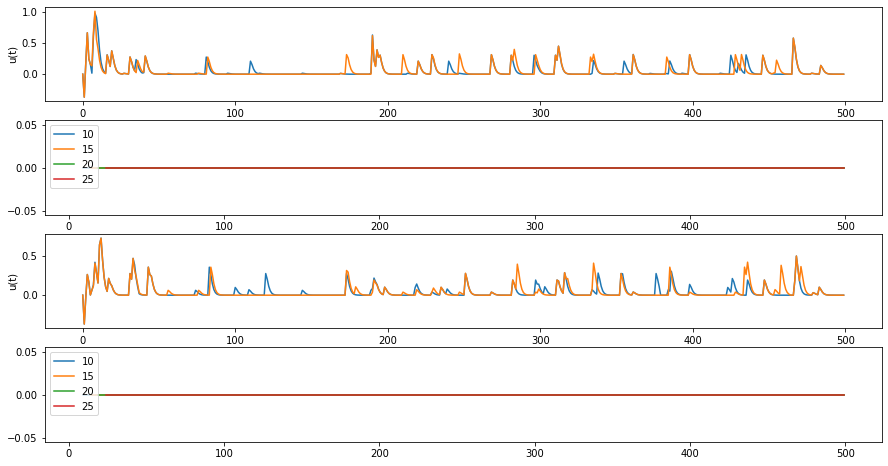

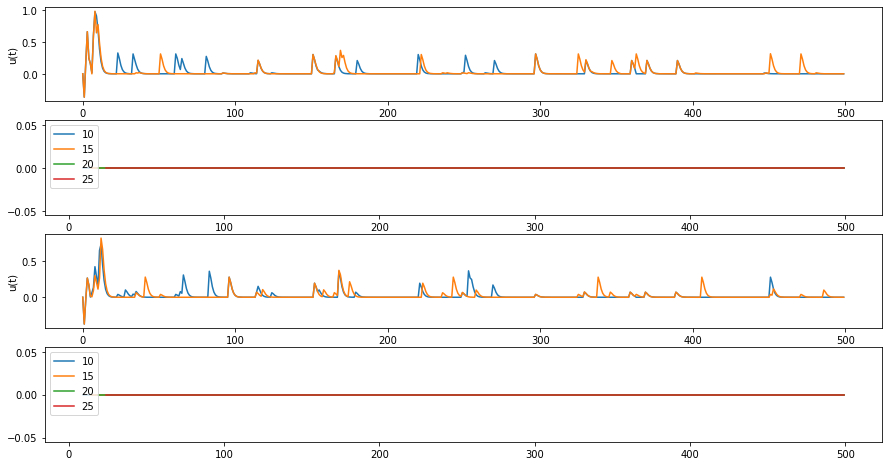

In [6]:
model = SRM(10)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

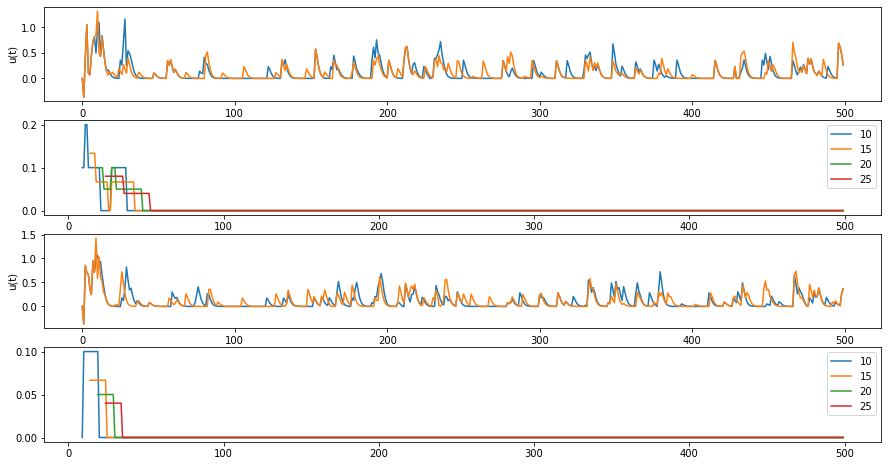

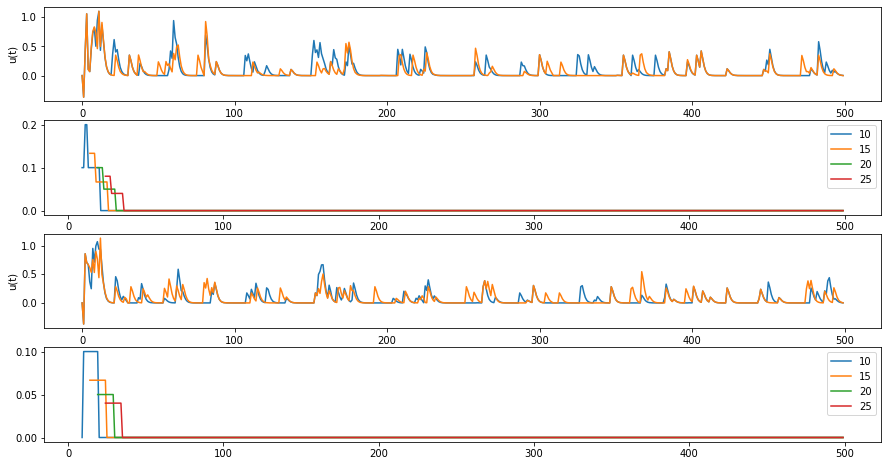

In [7]:
model = SRM(20)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

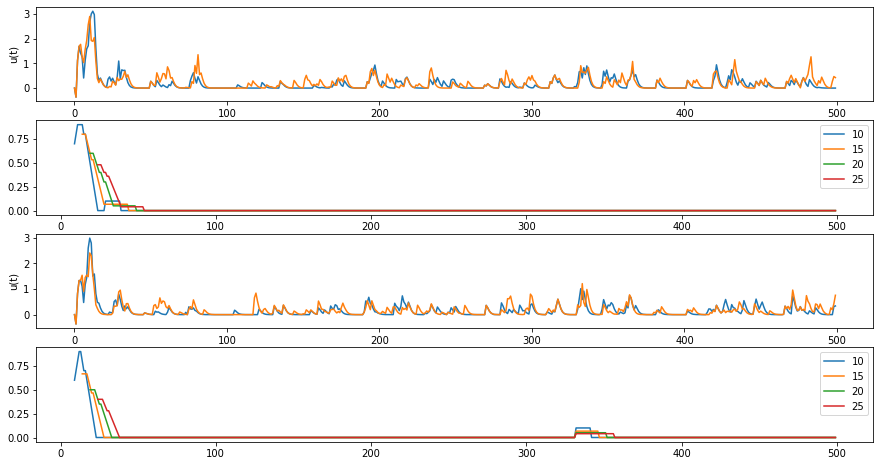

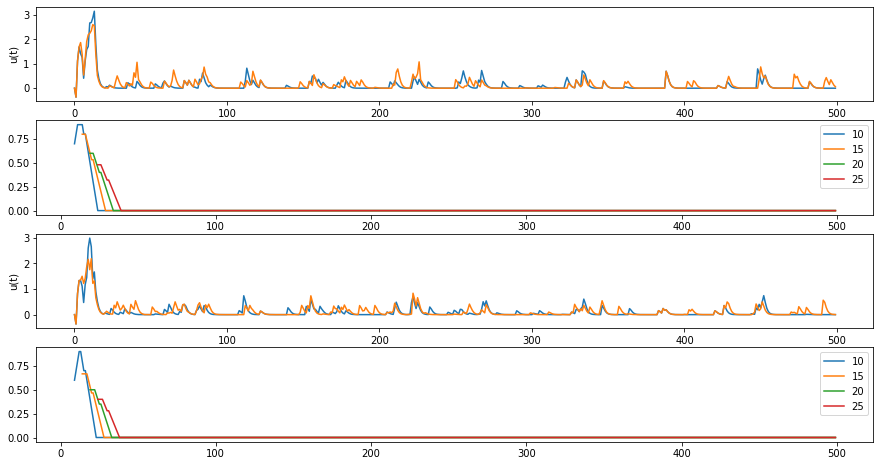

In [8]:
model = SRM(50)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

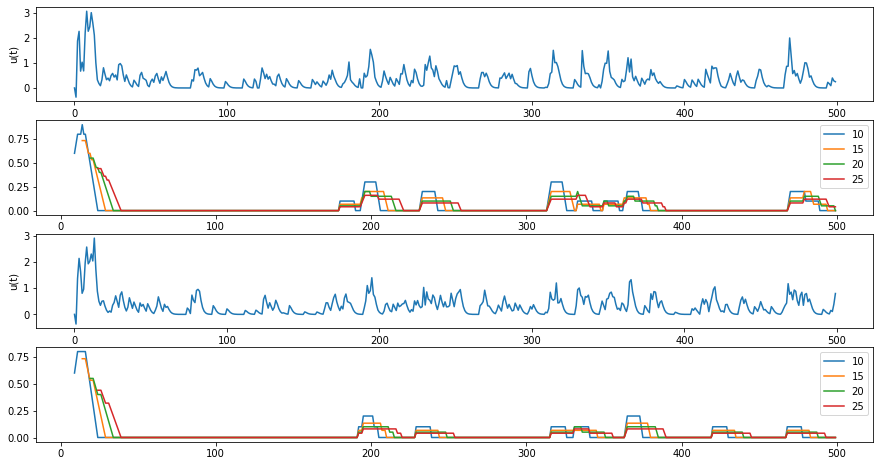

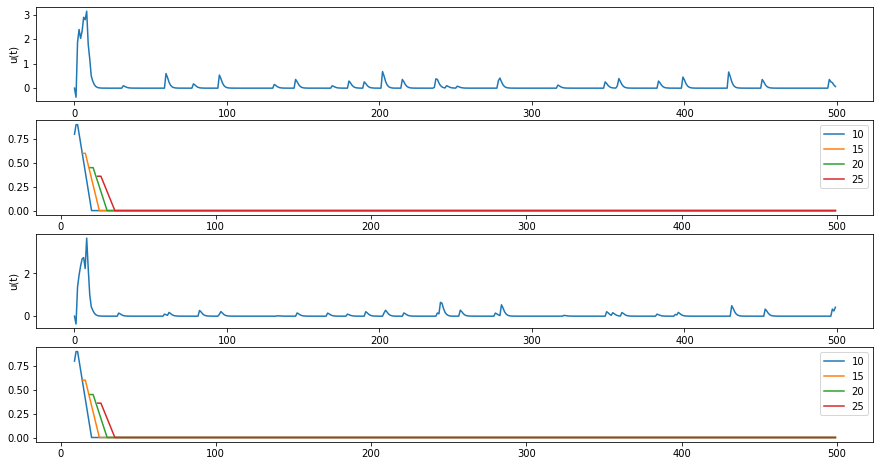

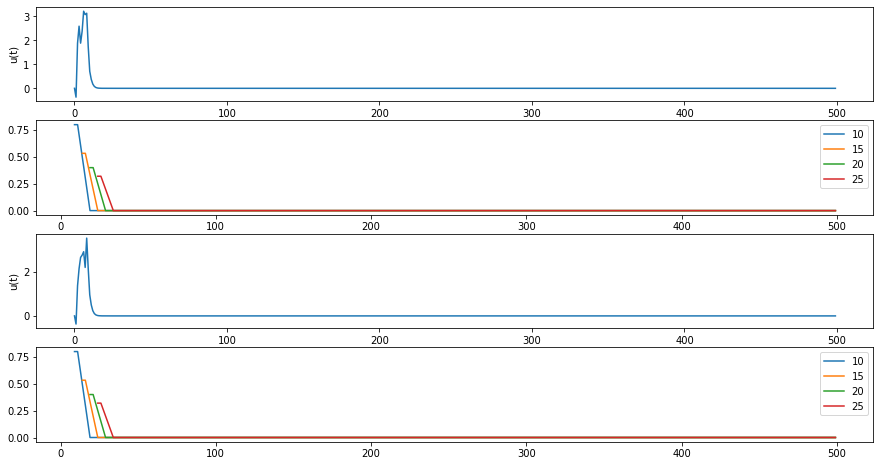

In [9]:
# Noise experiment.
model = SRM(50)
for p in (0.05, 0.5, 0.9):
    u1_noise = model(noise(x1, p))
    plot(u1_noise)

## STDP

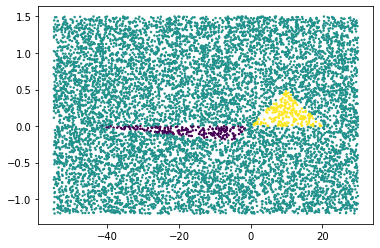

In [10]:
RED_TOP_DT, RED_TOP_W = 10, 0.5
BLUE_TOP_DT, BLUE_TOP_W = -5, -0.2
BLUE_LEFT_DT = -45
LTD, LTP = 0.01, -0.01


def stdp_func(dt, w):
    """Figure 12-3 from paper."""
    
    if dt == 0:
        return 0.0
    
    if BLUE_LEFT_DT <= dt < BLUE_TOP_DT:
        bot_w = BLUE_TOP_W * ((dt - BLUE_LEFT_DT) / (BLUE_TOP_DT - BLUE_LEFT_DT))
        is_in = (0 >= w >= bot_w)
        return int(is_in) * LTP
    elif BLUE_TOP_DT <= dt < 0:
        bot_w = BLUE_TOP_W - BLUE_TOP_W * ((dt - BLUE_TOP_DT) / (-BLUE_TOP_DT))
        is_in = (0 >= w >= bot_w)
        return int(is_in) * LTP
    elif 0 < dt <= RED_TOP_DT:
        top_w = RED_TOP_W * (dt / RED_TOP_DT)
        is_in = (0 <= w <= top_w)
        return int(is_in) * LTD
    elif RED_TOP_DT < dt <= 2 * RED_TOP_DT:
        top_w = RED_TOP_W - RED_TOP_W * ((dt - RED_TOP_DT) / (RED_TOP_DT))
        is_in = (0 <= w <= top_w)
        return int(is_in) * LTD
    else:
        return 0.0
    


# Test.
n = 10000
x = np.random.uniform(low=BLUE_LEFT_DT - 10, high=2 * RED_TOP_DT + 10, size=n)
y = np.random.uniform(low=BLUE_TOP_W - 1, high=RED_TOP_W + 1, size=n)
c = np.array([stdp_func(x1, y1) for x1, y1 in zip(x, y)])
plt.scatter(x, y, s=2.0, c=c);

In [11]:
class STDP(SRM):
    def w(self, w, tp, t):
        w = w.copy()
        for i in range(w.shape[0]):
            for j in range(w.shape[1]):
                w[i, j] += stdp_func(w[i, j], t - tp[i])

        return w

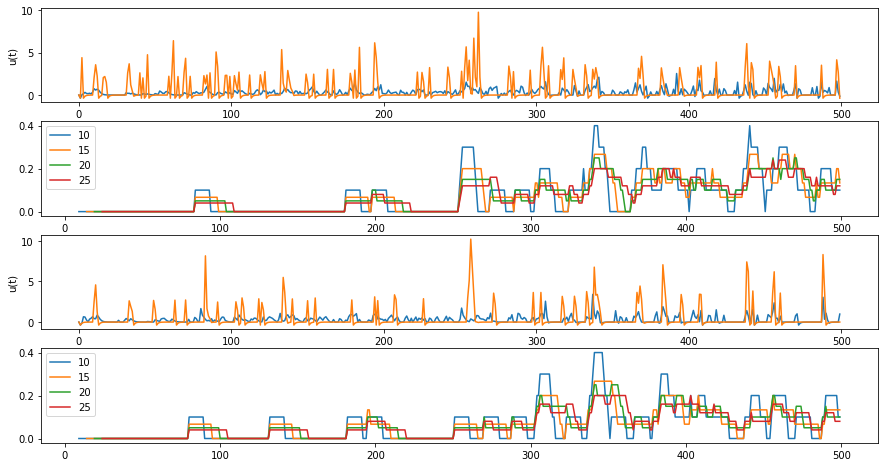

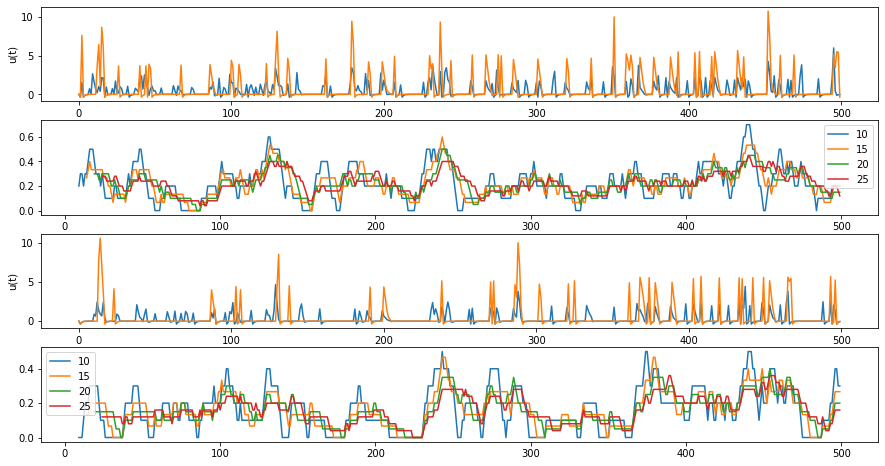

In [12]:
model = STDP(10)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

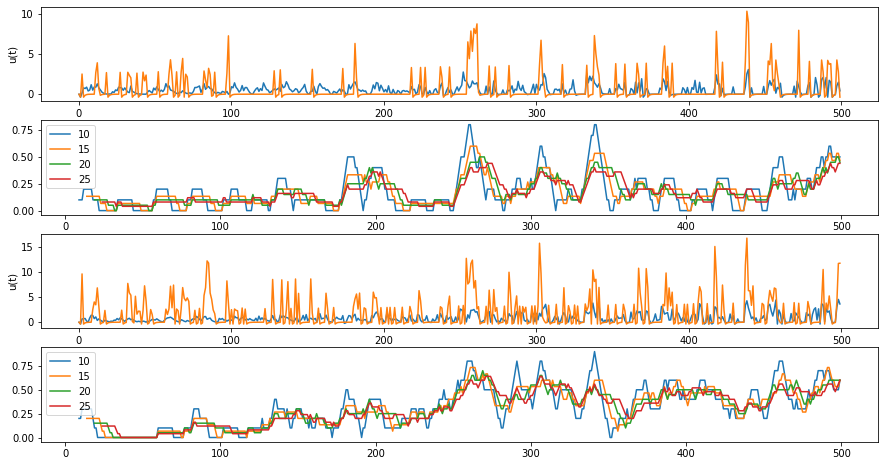

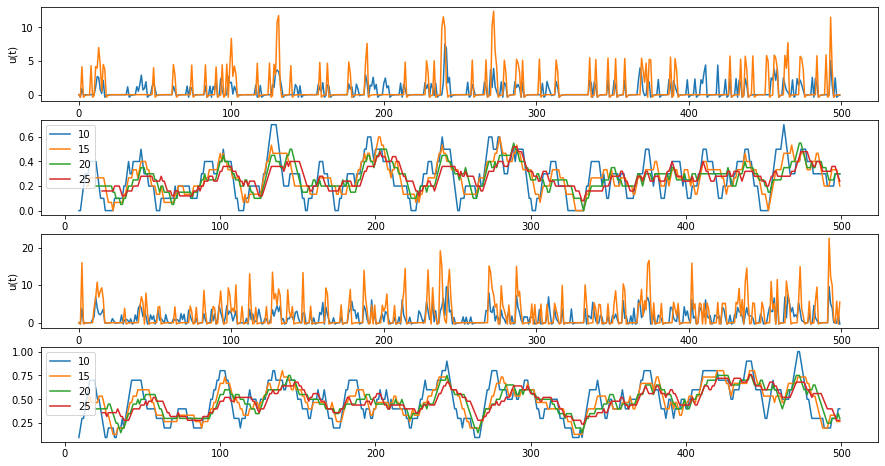

In [13]:
model = STDP(20)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

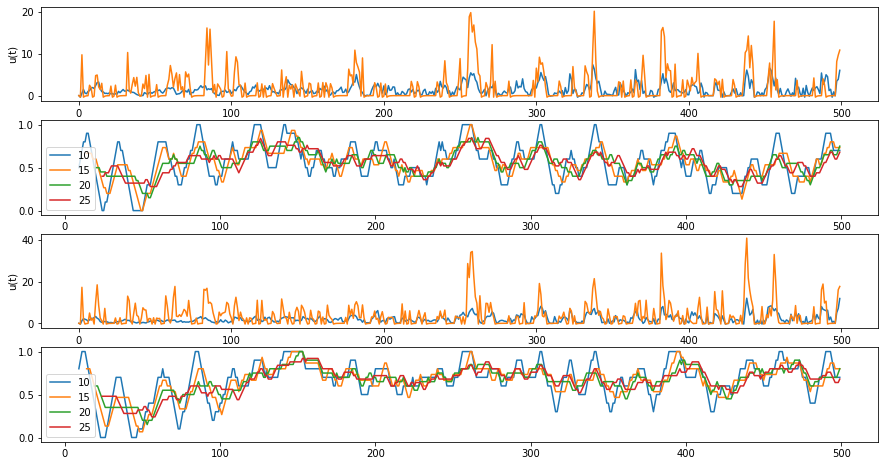

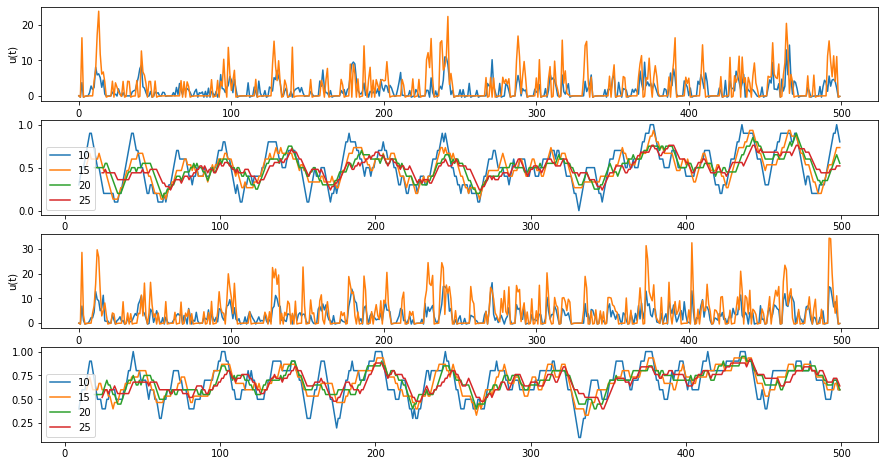

In [14]:
model = STDP(50)
u1, u2 = model(x1), model(x2)
u1_noise, u2_noise = model(x1_noise), model(x2_noise)
plot(u1, u1_noise)
plot(u2, u2_noise)

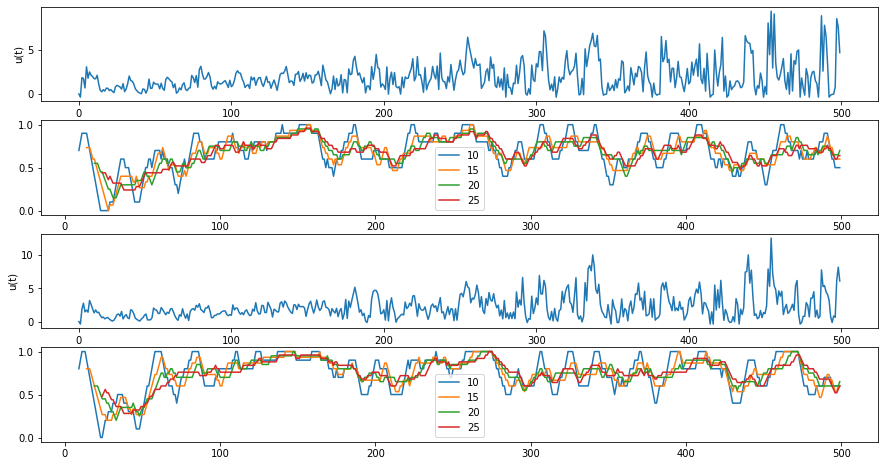

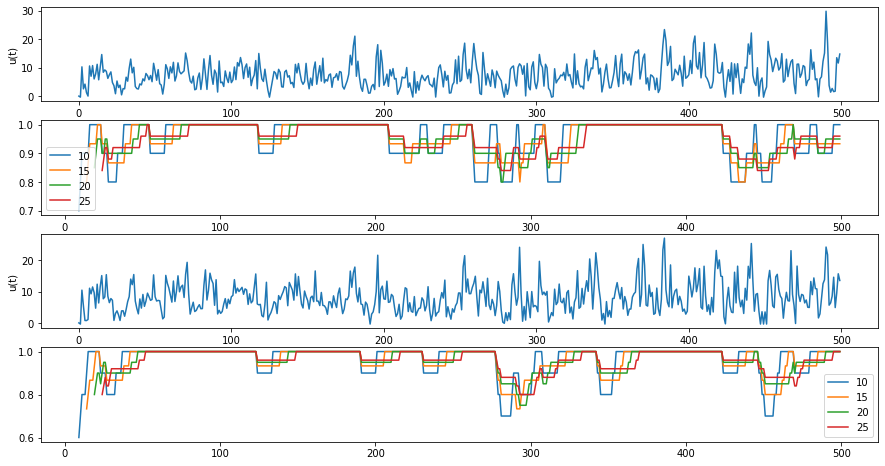

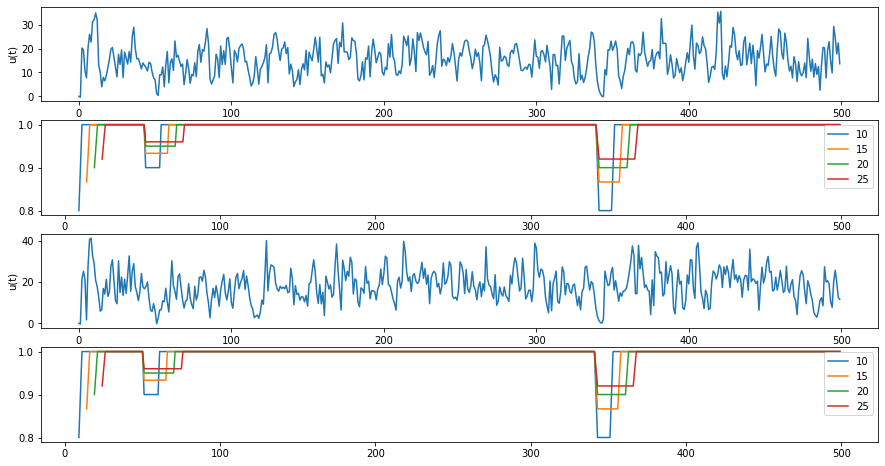

In [15]:
# Noise experiment.
model = STDP(50)
for p in (0.05, 0.5, 0.9):
    u1_noise = model(noise(x1, p))
    plot(u1_noise)